# Applicant Ranking

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_jobs = pd.read_csv('jobs.csv')
df_resume = pd.read_csv('resume_sections.csv')
df_resume.drop(columns=['INTERESTS', 'AWARDS'], inplace=True)
df_resume.fillna('', inplace=True)

In [3]:
df_jobs

,title,description,skills,education,experience
0,Senior Backend Developer,We are seeking a highly skilled Senior Backend...,"Python, Django, RESTful APIs, SQL",Bachelor in Computer Engineering,3 years of software development experience in ...
1,Full Stack Developer,We are hiring a versatile Full Stack Developer...,"HTML, CSS, JavaScript, Node.js, Express, Mongo...",Bachelor Degree in Computer Science,7 years of data analysis experience using Exce...
2,Python Backend Engineer,We have an exciting opportunity for a Python B...,"Python, Django, Flask, SQL, AWS",Masters in Computer Science,4 years of marketing experience with a focus o...
3,Backend Software Engineer,We are looking for a talented Backend Software...,"Java, Spring, Hibernate, RESTful APIs, MySQL",PhD in Computer Science,2 years of web development experience using Dj...
4,Junior Backend Developer,We are seeking a motivated Junior Backend Deve...,"Python, Django, Git, Linux, SQL",Bachelor in Computer Engineering,1 year of data analytics experience with Table...
5,Mid-Level Full Stack Developer,"Fully responsible for analysis, design, develo...","React.js, Node.js, HTML, CSS, JavaScript, Pyth...","Bachelor's degree in Computer Science, Enginee...",3 years


In [4]:
df_resume.head()

,EDUCATION,SKILLS,EXPERIENCE,Filename,PROFILE,PROJECTS,CERTIFICATIONS
0,Bachelor of Science Computer Science Oklahoma...,"HTML CSS Javascript Python C++ SQL (MySQL, Pos...",Web Developer ICF 2020 - current / Oklahoma Ci...,Albana_be,,,
1,"B.E., Electronics and Communication Engineerin...","Data Analysis and Statistics: JMP, Minitab De...",,Anil_Sharma,As an enthusiastic graduate with a degree in E...,,
2,Associate of Science Web Development Technolog...,Bootstrap React Git Visual Studio Code WordPre...,Web Developer Fanatics 2020 - current Jacksonv...,Ayla_Stone,,,
3,"Pokhara University , Lekhnath, Kaski Bachelor ...",Front-end : Angular.js Back-end : Python FastA...,Software Intern XYZ Tech Solutions 2021-2022 P...,Hari_Tamang_I,,Task Management System : • Developed a task ...,
4,Bachelor of Science Computer Science Universi...,HTML CSS JavaScript Angular Node SQL MongoDB C...,Junior Software Developer Revature LLC 2021 - ...,Ilias,,Tower Defense Mobile Game Creator 2018 - 2020 ...,


## Preprocessing

In [5]:
import re

def clean_description(text):
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\+]', ' ', text)
    # Remove extra blank spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Convert to lowercase
    text = text.lower()
    return text

clean_description("I have skills in developing applications using Python3, React.js, and JavaScript.      I can use Java, express.JS!")

'i have skills in developing applications using python react js and javascript i can use java express js'

In [6]:
# Combine text from all columns to get overall resume text
df_resume['clean_resume_text'] = df_resume[['PROFILE', 'EXPERIENCE', 'PROJECTS', 'CERTIFICATIONS']].apply(lambda row: ' '.join(row), axis=1).apply(clean_description)
df_resume.head(-5)[['Filename', 'PROFILE', 'EXPERIENCE', 'PROJECTS', 'clean_resume_text']]

,Filename,PROFILE,EXPERIENCE,PROJECTS,clean_resume_text
0,Albana_be,,Web Developer ICF 2020 - current / Oklahoma Ci...,,web developer icf current oklahoma city ok par...
1,Anil_Sharma,As an enthusiastic graduate with a degree in E...,,,as an enthusiastic graduate with a degree in e...
2,Ayla_Stone,,Web Developer Fanatics 2020 - current Jacksonv...,,web developer fanatics current jacksonville fl...
3,Hari_Tamang_I,,Software Intern XYZ Tech Solutions 2021-2022 P...,Task Management System : • Developed a task ...,software intern xyz tech solutions pokhara kas...
4,Ilias,,Junior Software Developer Revature LLC 2021 - ...,Tower Defense Mobile Game Creator 2018 - 2020 ...,junior software developer revature llc current...
5,Jaydeep_ml,,Research Intern - IIT Indore Biomedical Signal...,Acoustic Echo Cancellation(AEC) • In hands-fr...,research intern iit indore biomedical signal p...
6,Jeong_Kim,,DonationXchange - Web Developer Intern July 2...,Moody Messenger - Creator · Developed front...,donationxchange web developer intern july curr...
7,John_Doe,,______________________________________________...,,junior web developer november present resume w...
8,John_Doe_i,,RESUME WORDED & CO. (8 employee venture-backe...,,resume worded co employee venture backed recru...
9,Rabin_Adhi,"Effective Student committed to learning, devel...",Nepal Applied Mathematics and Informatics Inst...,Kukurshetra A cross platform desktop app writt...,effective student committed to learning develo...


In [7]:
df_resume.drop(columns=['PROFILE', 'CERTIFICATIONS'], inplace=True)

## Choose target job

In [8]:
target_job = df_jobs.loc[5]

Preprocess job description  
This adds the title, and skills to the description.  
Then cleans it.

In [9]:
def preprocess_job(target_job):
    title, description, skills = (
        target_job['title'],
        target_job['description'],
        target_job['skills'],
    )    # Clean description
    if skills:
        description = skills.replace(',', '') + ' ' + description
    if title:
        description = f'{title} {description}'
    description = clean_description(description)
    # print('Cleaned job description:', description)
    return description

## Sentence Transformer
For comparing job-description and resume-description

In [10]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained sentence transformer model
MODEL_NAME = 'bert-base-nli-mean-tokens'
model = SentenceTransformer(MODEL_NAME)

In [11]:
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

In [12]:
def get_description_score(target_job):
    job_embeddings = model.encode(preprocess_job(target_job))   
    # resume_embeddings = model.encode(df_resume['clean_resume_text'])

    resume_embeddings = np.zeros((len(df_resume), model.
    get_sentence_embedding_dimension()))
    for i in tqdm(range(len(df_resume)), desc='Encoding resume texts', unit='resumes'):
        resume_embeddings[i] = model.encode(df_resume.iloc[i]['clean_resume_text'])
    
    # Calculate cosine similarity between the job description and resumes
    cosine_similarities = cosine_similarity(resume_embeddings, [job_embeddings])

    # Set negative scores to 0
    cosine_similarities[cosine_similarities < 0] = 0

    df_resume['description_score'] = cosine_similarities

In [13]:
get_description_score(target_job)

df_resume[['Filename', 'clean_resume_text', 'description_score']]

Encoding resume texts: 100%|██████████| 18/18 [00:04<00:00,  3.76resumes/s]


,Filename,clean_resume_text,description_score
0,Albana_be,web developer icf current oklahoma city ok par...,0.650315
1,Anil_Sharma,as an enthusiastic graduate with a degree in e...,0.562714
2,Ayla_Stone,web developer fanatics current jacksonville fl...,0.624582
3,Hari_Tamang_I,software intern xyz tech solutions pokhara kas...,0.756559
4,Ilias,junior software developer revature llc current...,0.734833
5,Jaydeep_ml,research intern iit indore biomedical signal p...,0.569113
6,Jeong_Kim,donationxchange web developer intern july curr...,0.676882
7,John_Doe,junior web developer november present resume w...,0.534024
8,John_Doe_i,resume worded co employee venture backed recru...,0.647682
9,Rabin_Adhi,effective student committed to learning develo...,0.581667


## 1. Skills

#### How it works?
For each applicant, a binary vector is created where each element represents the presence (1) or absence (0) of a specific skill from the target job in the applicant's skills.

**Convert job description skills and applicant skills into binary feature vectors**

In [14]:
target_job['skills'].split(', ')

['React.js',
 'Node.js',
 'HTML',
 'CSS',
 'JavaScript',
 'Python',
 'Databases: SQL',
 'PostgreSQL']

In [15]:
df_resume['SKILLS']

0     HTML CSS Javascript Python C++ SQL (MySQL, Pos...
1     Data Analysis and Statistics:  JMP, Minitab De...
2     Bootstrap React Git Visual Studio Code WordPre...
3     Front-end : Angular.js Back-end : Python FastA...
4     HTML CSS JavaScript Angular Node SQL MongoDB C...
5     •  MATLAB, Xilinx ISE 12.1, MS Oﬃce, Proteus, ...
6     HTML; CSS; JavaScript; Python; REST APIs; Node...
7     ______________________________ Technical Skill...
8     : Advanced in SQL, PHP, Javascript, HTML/CSS; ...
9     Python  programming language including librari...
10    Front-End:  HTML, Svelte, Redux Back-end:  Dja...
11    Operating Systems:  Windows, Mac OSX, Linux Fr...
12    Front-end : HTML,CSS,JavaScript, React.js Back...
13    Operating Systems:  Windows, Mac OSX, Linux Pr...
14    •  Languages : Scala, Python, Javascript, C++,...
15    Programming Languages : JavaScript, Python, C/...
16    Bulma Subversion Angular GIMP Wix Google Chrom...
17    JavaScript HTML CSS PHP Python React.js Ma

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer

# Helper function to check if a skill is present in the resume description
def skill_present(skill, description):
    # Use regular expression pattern matching to match the whole word
    pattern = r"\b" + re.escape(skill) + r"\b"
    return bool(re.search(pattern, description, re.IGNORECASE))


def vectorize_skills(df_resume_texts):
    # Remove '.js' extension from the skill to handle cases like 'react.js' and 'react'
    target_job_skills_text = target_job['skills'].replace('.js', '')
    # The 'skills' column has string values. Each string has skills sepearated by comma. So convert them to array of skills.
    target_job_skills = target_job_skills_text.lower().split(', ')
    # Initialize the MultiLabelBinarizer
    mlb = MultiLabelBinarizer(classes=target_job_skills)

    # Create a list of skills for each applicant's project
    applicant_skills_vector = df_resume_texts.apply(lambda x: [skill for skill in target_job_skills if skill_present(skill, x)])

    # Use the MultiLabelBinarizer to transform the 'skills' column into binary vectors
    applicant_binary_vectors = mlb.fit_transform(applicant_skills_vector)

    return applicant_binary_vectors.tolist()


In [17]:
df_resume['skills_vector'] = vectorize_skills(df_resume['SKILLS'])
df_resume[['Filename', 'SKILLS', 'skills_vector']]

,Filename,SKILLS,skills_vector
0,Albana_be,"HTML CSS Javascript Python C++ SQL (MySQL, Pos...","[0, 0, 1, 1, 1, 1, 0, 1]"
1,Anil_Sharma,"Data Analysis and Statistics: JMP, Minitab De...","[1, 1, 0, 0, 1, 1, 0, 0]"
2,Ayla_Stone,Bootstrap React Git Visual Studio Code WordPre...,"[1, 0, 0, 0, 0, 0, 0, 0]"
3,Hari_Tamang_I,Front-end : Angular.js Back-end : Python FastA...,"[0, 0, 0, 0, 0, 1, 0, 1]"
4,Ilias,HTML CSS JavaScript Angular Node SQL MongoDB C...,"[0, 1, 1, 1, 1, 0, 0, 0]"
5,Jaydeep_ml,"• MATLAB, Xilinx ISE 12.1, MS Oﬃce, Proteus, ...","[0, 0, 0, 0, 0, 1, 0, 0]"
6,Jeong_Kim,HTML; CSS; JavaScript; Python; REST APIs; Node...,"[1, 1, 1, 1, 1, 1, 0, 0]"
7,John_Doe,______________________________ Technical Skill...,"[1, 0, 0, 0, 0, 0, 0, 0]"
8,John_Doe_i,": Advanced in SQL, PHP, Javascript, HTML/CSS; ...","[0, 0, 1, 1, 1, 1, 0, 0]"
9,Rabin_Adhi,Python programming language including librari...,"[1, 1, 0, 0, 1, 1, 0, 0]"


In [18]:
target_job['skills_vector'] = np.ones(len(target_job['skills'].split(', ')))
target_job.skills, target_job.skills_vector

('React.js, Node.js, HTML, CSS, JavaScript, Python, Databases: SQL, PostgreSQL',
 array([1., 1., 1., 1., 1., 1., 1., 1.]))

In [19]:
def get_skills_score():
    target_vector = np.array(target_job['skills_vector']).reshape(1, -1)
    applicant_vector = np.array(df_resume['skills_vector'].tolist())
    similarity_scores = cosine_similarity(target_vector, applicant_vector)
    df_resume['skills_score'] = similarity_scores.flatten()

# target_vector is created from target_job['skills_vector']. It's reshaped to a 2D array with reshape(1, -1) because cosine_similarity expects a 2D array.
# applicant_vectors is created by converting df_resume['skills_vector'] to a NumPy array using tolist(). This is done because cosine_similarity expects a 2D array.

In [20]:
get_skills_score()

In [21]:
df_resume[['Filename', 'SKILLS', 'skills_vector', 'skills_score']]

,Filename,SKILLS,skills_vector,skills_score
0,Albana_be,"HTML CSS Javascript Python C++ SQL (MySQL, Pos...","[0, 0, 1, 1, 1, 1, 0, 1]",0.790569
1,Anil_Sharma,"Data Analysis and Statistics: JMP, Minitab De...","[1, 1, 0, 0, 1, 1, 0, 0]",0.707107
2,Ayla_Stone,Bootstrap React Git Visual Studio Code WordPre...,"[1, 0, 0, 0, 0, 0, 0, 0]",0.353553
3,Hari_Tamang_I,Front-end : Angular.js Back-end : Python FastA...,"[0, 0, 0, 0, 0, 1, 0, 1]",0.500000
4,Ilias,HTML CSS JavaScript Angular Node SQL MongoDB C...,"[0, 1, 1, 1, 1, 0, 0, 0]",0.707107
5,Jaydeep_ml,"• MATLAB, Xilinx ISE 12.1, MS Oﬃce, Proteus, ...","[0, 0, 0, 0, 0, 1, 0, 0]",0.353553
6,Jeong_Kim,HTML; CSS; JavaScript; Python; REST APIs; Node...,"[1, 1, 1, 1, 1, 1, 0, 0]",0.866025
7,John_Doe,______________________________ Technical Skill...,"[1, 0, 0, 0, 0, 0, 0, 0]",0.353553
8,John_Doe_i,": Advanced in SQL, PHP, Javascript, HTML/CSS; ...","[0, 0, 1, 1, 1, 1, 0, 0]",0.707107
9,Rabin_Adhi,Python programming language including librari...,"[1, 1, 0, 0, 1, 1, 0, 0]",0.707107


## 2. Projects

#### How it works?
***It checks if the applicant has made at least one project using the required skills or not.***

1. The job description skills are converted into a binary feature vector, where each element represents the presence or absence of a skill in the job description.

2. A helper function skill_present is defined to check if a skill is present in the project description using regular expression pattern matching to match the whole word.

3. The vectorize_project function takes the applicant projects and job skills as input and converts the project descriptions into binary feature vectors. For each applicant, it iterates over the skills and checks if any of the skills are present in the project descriptions using the skill_present function.

4. The cosine similarity is calculated between the job_skills_vector and each applicant's project vector using the cosine_similarity function. The similarity score represents how closely the applicant's projects match the job description skills.

Testing the vectorization of projects description

In [136]:
projects = [
    'i have done project in (python, django rest).', 
    ' javaScript, next.js, reactjs',
    ' py. django-rest, r(java), NodeJS. Next.js'
]
projects = pd.Series(projects)
app_vec = projects.apply(lambda x: [skill for skill in ['Python', 'Django', 'Django rest', 'java', 'js', 'react', 'next', 'nodejs'] if skill_present(skill, x)])
print(app_vec)

0       [Python, Django, Django rest]
1                          [js, next]
2    [Django, java, js, next, nodejs]
dtype: object


In [137]:
# Convert applicant projects into binary feature vectors
df_resume['projects_vector'] = vectorize_skills(df_resume['PROJECTS'])

In [138]:
def get_projects_score():
    target_vector = np.array(target_job['skills_vector']).reshape(1, -1)
    applicant_vector = np.array(df_resume['projects_vector'].tolist())
    similarity_scores = cosine_similarity(target_vector, applicant_vector)
    df_resume['projects_score'] = similarity_scores.flatten()

# target_vector is created from target_job['skills_vector']. It's reshaped to a 2D array with reshape(1, -1) because cosine_similarity expects a 2D array.
# applicant_vectors is created by converting df_resume['projects_vector'] to a NumPy array using tolist(). This is done because cosine_similarity expects a 2D array.

In [139]:
get_projects_score()

In [140]:
df_resume[['Filename', 'PROJECTS', 'projects_vector', 'projects_score']]

,Filename,PROJECTS,projects_vector,projects_score
0,Albana_be,,"[0, 0, 0, 0, 0, 0, 0, 0]",0.000000
1,Anil_Sharma,,"[0, 0, 0, 0, 0, 0, 0, 0]",0.000000
2,Ayla_Stone,,"[0, 0, 0, 0, 0, 0, 0, 0]",0.000000
3,Hari_Tamang_I,Task Management System : • Developed a task ...,"[1, 1, 1, 1, 1, 0, 0, 1]",0.866025
4,Ilias,Tower Defense Mobile Game Creator 2018 - 2020 ...,"[0, 0, 1, 0, 1, 0, 0, 0]",0.500000
5,Jaydeep_ml,Acoustic Echo Cancellation(AEC) • In hands-fr...,"[0, 0, 0, 0, 0, 0, 0, 0]",0.000000
6,Jeong_Kim,Moody Messenger - Creator · Developed front...,"[1, 0, 1, 1, 0, 1, 0, 0]",0.707107
7,John_Doe,,"[0, 0, 0, 0, 0, 0, 0, 0]",0.000000
8,John_Doe_i,,"[0, 0, 0, 0, 0, 0, 0, 0]",0.000000
9,Rabin_Adhi,Kukurshetra A cross platform desktop app writt...,"[0, 0, 0, 0, 0, 1, 0, 1]",0.500000


## 3. Education

### Identify Degree and Major in Education

Our system uses spacy library to extract information (degree and major) from Education. We prepared a dictionary that has all education degrees and majors related to computer engineering field. We fed that dictionary to the Spacy rule-based EntityRuler in order to detect and recognize entities in our job description.

In [141]:
import spacy
from spacy import displacy

In [142]:
df_resume['EDUCATION'][5], target_job['education']

('B.Tech. (ECE) - 9.0 CGPA Jaypee University of Engineering & Tech- nology �  July 2016 – Currently Higher Secondary - 71% Central Board of Secondary Education �  2016 Secondary - 7.8 CGPA Central Board of Secondary Education �  2014 ',
 "Bachelor's degree in Computer Science, Engineering, or a related field.")

In [143]:
def match_degrees_by_spacy(education_text, nlp):
    doc = nlp(education_text)
    degree_levels = []
    for ent in doc.ents:
        labels_parts = ent.label_.split('|')
        if labels_parts[0] == 'DEGREE':
            # print((ent.text, ent.label_))
            if labels_parts[1] not in degree_levels:
                degree_levels.append(labels_parts[1])
    return degree_levels

def match_majors_by_spacy(education_text, nlp):
    doc = nlp(education_text)
    acceptable_majors = []
    for ent in doc.ents:
        labels_parts = ent.label_.split('|')
        if labels_parts[0] == 'MAJOR':
            acceptable_majors.append(labels_parts[1:])
    return acceptable_majors


# Function to extract degree level and field of study from education
def extract_education_info(df_resume, target_job):
    # Initialize the NLP pipeline and entity ruler
    nlp = spacy.load("en_core_web_sm")
    # Disable the default 'ner' component
    nlp.disable_pipe('ner')
    # Add the pattern to the matcher
    PATTERN_PATH = 'degrees_majors.jsonl'
    ruler = nlp.add_pipe("entity_ruler", before='ner')
    # Load the degree and major patterns
    ruler.from_disk(PATTERN_PATH)

    # Initialize lists to store the results
    resume_degrees = []
    resume_majors = []

    # Extract degree and major for each resume
    for education_text in df_resume["EDUCATION"]:
        degrees = match_degrees_by_spacy(education_text, nlp)
        majors = match_majors_by_spacy(education_text, nlp)
        resume_degrees.append(degrees)
        resume_majors.append(majors)

    # Extract degree and major for the target job
    job_degree = match_degrees_by_spacy(target_job["education"], nlp)
    job_major = match_majors_by_spacy(target_job["education"], nlp)

    (
        df_resume["education_degree"],
        df_resume["education_major"],
        target_job["education_degree"],
        target_job["education_major"],
    ) = (resume_degrees, resume_majors, job_degree, job_major)

    return resume_degrees, resume_majors, job_degree, job_major

#### How it works?
It considers two factors seperately: degree and field of study.

1. Degree
- Values are assigned to different degree levels. Eg: Bachelor=1, Master=2, PhD=3
- It maps degree levels to numerical values, finds the highest degree for each resume.
- Converts the job degree to numerical form, and calculates a degree score based on a scoring formula.
- If the highest degree in a resume is greater than or equal to the minimum job degree, the score is 1,
- Otherwise, it is calculated using a formula that considers the difference between the degrees.

2. Field of Study
- measures the similarity between the applicant's field of study and the job's required field of study.

3. Combining Degree and Field Scores
The degree score is weighted by 0.7, and the field score is weighted by 0.3.


Education Degree Score

In [144]:
"""
# The major is divided into three parts: 1st part, 2nd part, and 3rd part. Each part of the major represents a level of specificity in the field of study.
# By breaking down the major into these parts, the code attempts to capture a hierarchy of specificity, allowing for partial matches to be considered in a structured manner. 
# A similarity score is assigned based on partial matches in the 1st, 2nd, and 3rd parts of the major.
Example:
    job_major = ['CS', 'AI', 'machine-learning']
    resume_major = [['CS', 'CS', 'computer-science'], ['CS', 'AI', 'data-science']]
    # Output: Major Score: 0.6 (based on the partial match in the 2nd part i.e. 'AI')
"""
def calculate_education_major_similarity(resume_major, job_major):
    score = 0.0
    for major in resume_major:
        # Check for an exact match in the 3rd part
        if job_major[2] == major[2]:
            score = 1.0 # max_score reached
            break
        # Check for a match in the 2nd part
        elif job_major[1] == major[1]:
            score = max(score, 0.6)
        # Check for a match in the 1st part
        elif job_major[0] == major[0]:
            score = max(score, 0.3)
    return score


def get_education_major_score(resume_majors, job_major):
    field_scores = []

    for resume_major in resume_majors:
        field_score = 0
        similarities = [
            calculate_education_major_similarity(resume_major, required_major)
            for required_major in job_major
        ]
        # Find max similarity score
        if similarities:
            field_score = max(similarities)
        field_scores.append(field_score)

    return field_scores


"""
Function to calculate degree score:
- It maps degree levels to numerical values, finds the highest degree for each resume,
- Converts the job degree to numerical form, and calculates a degree score based on a scoring formula.
- If the highest degree in a resume is greater than or equal to the minimum job degree, the score is 1,
- Otherwise, it is calculated using a formula that considers the difference between the degrees.
"""

# Define a mapping for degree levels
degree_mapping = {
    'BACHELOR': 1,
    'MASTER': 2,
    'PHD': 3,
}

def get_education_degree_score(resume_degrees, job_degree):
    # Apply the mapping to the list of degrees
    numerical_degrees = [[degree_mapping.get(degree, 0) for degree in degrees] for degrees in resume_degrees]
    # Get the highest degree for each resume
    applicant_degrees = [max(degrees) if degrees else 0 for degrees in numerical_degrees]

    # Convert the job degree to numerical form
    numerical_job_degree = [degree_mapping.get(degree, 0) for degree in job_degree]
    # Get the minimum degree required for the job
    min_degree_required = min(numerical_job_degree)

    degree_scores = []
    for applicant_degree in applicant_degrees:
        degree_score = 0
        
        if applicant_degree >= min_degree_required:
            degree_score = 1
        else:
            degree_score = 1- (min_degree_required-applicant_degree)/max(min_degree_required, 1)

        degree_scores.append(degree_score)

    return degree_scores
        

def get_education_score(df_resume, target_job):
    resume_degrees, resume_majors, job_degree, job_major = extract_education_info(
        df_resume, target_job
    )

    degree_scores = get_education_degree_score(resume_degrees, job_degree)
    field_scores = get_education_major_score(resume_majors, job_major)

    # Set weights for degree and field_of_study
    degree_weight = 0.7
    field_weight = 0.3

    combined_scores = [degree_weight * degree_score + field_weight * field_score for degree_score, field_score in zip(degree_scores, field_scores)]

    # df_resume['degree_score'] = degree_scores
    # df_resume['major_score'] = field_scores
    df_resume['education_score'] = combined_scores

In [145]:
get_education_score(df_resume, target_job)

In [146]:
target_job[['education', 'education_degree', 'education_major']]

education           Bachelor's degree in Computer Science, Enginee...
education_degree                                           [BACHELOR]
education_major                          [[CS, CS, computer-science]]
Name: 5, dtype: object

In [147]:
df_resume[['Filename', 'EDUCATION', 'education_degree', 'education_major', 'education_score']]

,Filename,EDUCATION,education_degree,education_major,education_score
0,Albana_be,Bachelor of Science Computer Science Oklahoma...,[BACHELOR],"[[CS, CS, computer-science]]",1.00
1,Anil_Sharma,"B.E., Electronics and Communication Engineerin...",[BACHELOR],"[[CS, AI, data-science]]",0.79
2,Ayla_Stone,Associate of Science Web Development Technolog...,[],"[[CS, DEV, web-development]]",0.09
3,Hari_Tamang_I,"Pokhara University , Lekhnath, Kaski Bachelor ...",[BACHELOR],"[[CS, CS, computer-science]]",1.00
4,Ilias,Bachelor of Science Computer Science Universi...,[BACHELOR],"[[CS, CS, computer-science]]",1.00
5,Jaydeep_ml,B.Tech. (ECE) - 9.0 CGPA Jaypee University of ...,[BACHELOR],[],0.70
6,Jeong_Kim,General Assembly - Certiﬁed Web Developer 202...,[],[],0.00
7,John_Doe,______________________________ Resume Worded U...,"[BACHELOR, MASTER]","[[CS, CS, computer-science]]",1.00
8,John_Doe_i,"RESUME WORDED UNIVERSITY Boston, MA Bachelor o...",[BACHELOR],"[[CS, CS, computer-science], [CS, CS, software...",1.00
9,Rabin_Adhi,Bachelor in Computer Engineering November 2017...,[BACHELOR],"[[CS, CS, computer-engineering]]",0.88


## 4. Experience

- Extracts the 'X years' part from the target job experience.
- Calculates similarity scores for each applicant's experience, taking the ratio of their 'X years' to the target job's 'X years'. 
- The score is limited it to a maximum of 1.0 to avoid giving excessive credit to applicants with more experience than needed.

In [148]:
df_resume['EXPERIENCE'][7]

'______________________________________________________________________ Junior Web Developer November 2015 – Present Resume Worded, New York, NY ● Analyzed and ﬁxed web application issues sent in by 13 RW departments including, customer support, achieving an 85% success rate. ● Launched 8 new websites using RW technologies like Resume Studio 2009 and RQL Server 2015, rewarded with a promotion for being proactive. ● Developed a database that tracked 3.6K individuals affected by natural disasters in 5 states., reducing costs associated with physical labor by 87%. ● Created an employment application portal including database design, graphic design, SSL, and email notiﬁcations for RW within 6 weeks of joining the organization. Software Developer February 2013 – October 2015 Growthsi, San Francisco, CA ● Overhauled the coding process, scheduling, quality assurance, and ticketing system, increasing the productivity of Growthsi IT department by 49% YoY. ● Created a data dictionary generator t

Minimum years of experience for target job

In [149]:
import re

# Function to extract years of exp from job description
def extract_min_experience(text):
    # Define the regular expression patterns
    pattern_months = r'(\d+)(?=\s*month)'
    pattern_years = r'(\d+)(?=\s*year)'
    
    # Use search to get the first match
    match_years = re.search(pattern_years, text)
    match_months = re.search(pattern_months, text)
    
    # If a match was found, convert it to an integer and return
    if match_years:
        return int(match_years.group())
    elif match_months:
        return int(match_months.group()) / 12  # Convert months to years
    
    # If no match was found, return None
    return 0

# Convert job experience to 'X years' information
extract_min_experience(target_job['experience'])

3

Create EntityRuler to extract dates from experience information

In [150]:
import spacy

def create_nlp_for_experience():
    nlp = spacy.load("en_core_web_sm")

    VALID_MONTH_NAMES = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec", "january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december"]


    # Most of the date patterns are detected by default DATE entity
    # Define the pattern for '05/2015 - 06/2017' and '10/2020 - Present'.
    patterns = [
        # 05/2015 - 06/2017
        {"label": "DATE", "pattern": [{"SHAPE": "dd/dddd"}, {"TEXT": "-"}, {"SHAPE": "dd/dddd"}]},

        # 10/2020 - Present
        {"label": "DATE", "pattern": [{"SHAPE": "dd/dddd"}, {"TEXT": "-"}, {"LOWER": "present"}]},
        {"label": "DATE", "pattern": [{"SHAPE": "dd/dddd"}, {"TEXT": "-"}, {"LOWER": "current"}]},

        # Jan 2020 - current, March 2018 - Present
        {"label": "DATE", "pattern": [{"LOWER": {"in": VALID_MONTH_NAMES}}, {"TEXT": {"REGEX": "^\d{4}$"}}, {"TEXT": "-"}, {"LOWER": {"in": ["current", "present"]}}]},

        # Jun 2016 - Sep 2016
        {"label": "DATE", "pattern": [{"LOWER": {"in": VALID_MONTH_NAMES}},
        {"TEXT": {"REGEX": "^\d{4}$"}}, {"TEXT": "-"}, {"LOWER": {"in": VALID_MONTH_NAMES}}, {"TEXT": {"REGEX": "^\d{4}$"}}]},

        # 2020 - current
        {"label": "DATE", "pattern": [{"SHAPE": "dddd"}, {"TEXT": "-"}, {"LOWER": {"in": ["current", "present"]}}]},
        ]

    ruler = nlp.add_pipe("entity_ruler", before='ner')
    # Add the pattern to the ruler
    ruler.add_patterns(patterns)

    return nlp

Calculate years of experience from applicant's resume

In [151]:
from dateutil import parser
from dateutil.relativedelta import relativedelta
from datetime import datetime

def extract_years(dates):
    years = 0
    for date in dates:
        # Check if the date is in the "start - end" format
        if '-' not in date:
            continue
        
        try:
            # Split the date range into start and end dates
            start_date, end_date = date.split('-')
            
            # Replace 'Present' or 'current' with today's date
            if 'present' in end_date.lower() or 'current' in end_date.lower():
                end_date = datetime.today().strftime('%m/%Y')
            
            # Parse the dates
            start_date = parser.parse(start_date)
            end_date = parser.parse(end_date)
            
            # Calculate the difference in years (considering months)
            diff = relativedelta(end_date, start_date)
            years += round(diff.years + diff.months / 12, 2)
        
        except ValueError as e:
            print(f"Error parsing dates: {e}. Skipping this entry.")
        
    return years

In [161]:
def get_experience_score():
    target_job_experience = extract_min_experience(target_job['experience'])
    
    nlp = create_nlp_for_experience()

    # First, replace En-dash '–' with Hyphen '-' before NER. e.g. Jun 2018 – Present
    df_resume['EXPERIENCE'] = df_resume['EXPERIENCE'].str.replace('–', '-').str.replace("—", "-")

    experience_date_vectors = []
    experience_years = []
    # Calculate similarity scores for each applicant
    applicant_scores = []
    for applicant_experience in df_resume['EXPERIENCE']:
        doc = nlp(applicant_experience)

        # Extract the dates that are in the 'start - end' format
        extracted_dates = [ent.text for ent in doc.ents if ent.label_ == 'DATE' and '-' in ent.text]
        experience_date_vectors.append(extracted_dates)

        applicant_years = extract_years(extracted_dates)
        experience_years.append(applicant_years)

        if target_job_experience == 0: # no experience requireed
            similarity_score = 1.0
        else:  
            similarity_score = min(applicant_years / target_job_experience, 1.0)
        applicant_scores.append(similarity_score)

    df_resume['experience_dates'] = experience_date_vectors
    df_resume['experience_years'] = experience_years
    df_resume['experience_score'] = applicant_scores

In [162]:
get_experience_score()

Error parsing dates: Unknown string format: day. Skipping this entry.


In [163]:
target_job['experience']

'3 years'

In [164]:
df_resume[['Filename', 'EXPERIENCE', 'experience_dates', 'experience_years', 'experience_score']]

,Filename,EXPERIENCE,experience_dates,experience_years,experience_score
0,Albana_be,Web Developer ICF 2020 - current / Oklahoma Ci...,"[2020 - current, 2017 - 2020, 2015 - 2017]",9.00,1.000000
1,Anil_Sharma,,[],0.00,0.000000
2,Ayla_Stone,Web Developer Fanatics 2020 - current Jacksonv...,[2020 - current],4.00,1.000000
3,Hari_Tamang_I,Software Intern XYZ Tech Solutions 2021-2022 P...,[2021-2022],1.00,0.333333
4,Ilias,Junior Software Developer Revature LLC 2021 - ...,[2021 - current],3.00,1.000000
5,Jaydeep_ml,Research Intern - IIT Indore Biomedical Signal...,"[June 2019 - July 2019, Oct 2018 - Jan 2019]",0.33,0.110000
6,Jeong_Kim,DonationXchange - Web Developer Intern July 2...,[July 2021 - current],2.58,0.860000
7,John_Doe,______________________________________________...,"[November 2015 - Present, February 2013 - Octo...",13.50,1.000000
8,John_Doe_i,RESUME WORDED & CO. (8 employee venture-backe...,"[Jun 2017 - Sep 2017, Jun 2016 - Sep 2016, 3-day]",0.50,0.166667
9,Rabin_Adhi,Nepal Applied Mathematics and Informatics Inst...,"[June 2020 - Present, Feb 2020 - Present]",7.67,1.000000


#### Finally, so far

In [165]:
df_resume.head()

,EDUCATION,SKILLS,EXPERIENCE,Filename,PROJECTS,clean_resume_text,description_score,skills_vector,skills_score,projects_vector,projects_score,education_degree,education_major,education_score,experience_dates,experience_years,experience_score,total_score
0,Bachelor of Science Computer Science Oklahoma...,"HTML CSS Javascript Python C++ SQL (MySQL, Pos...",Web Developer ICF 2020 - current / Oklahoma Ci...,Albana_be,,web developer icf current oklahoma city ok par...,0.650315,"[0, 0, 1, 1, 1, 1, 0, 1]",0.790569,"[0, 0, 0, 0, 0, 0, 0, 0]",0.000000,[BACHELOR],"[[CS, CS, computer-science]]",1.00,"[2020 - current, 2017 - 2020, 2015 - 2017]",9.0,1.000000,0.805661
1,"B.E., Electronics and Communication Engineerin...","Data Analysis and Statistics: JMP, Minitab De...",,Anil_Sharma,,as an enthusiastic graduate with a degree in e...,0.562714,"[1, 1, 0, 0, 1, 1, 0, 0]",0.707107,"[0, 0, 0, 0, 0, 0, 0, 0]",0.000000,[BACHELOR],"[[CS, AI, data-science]]",0.79,[],0.0,0.000000,0.383828
2,Associate of Science Web Development Technolog...,Bootstrap React Git Visual Studio Code WordPre...,Web Developer Fanatics 2020 - current Jacksonv...,Ayla_Stone,,web developer fanatics current jacksonville fl...,0.624582,"[1, 0, 0, 0, 0, 0, 0, 0]",0.353553,"[0, 0, 0, 0, 0, 0, 0, 0]",0.000000,[],"[[CS, DEV, web-development]]",0.09,[2020 - current],4.0,1.000000,0.532398
3,"Pokhara University , Lekhnath, Kaski Bachelor ...",Front-end : Angular.js Back-end : Python FastA...,Software Intern XYZ Tech Solutions 2021-2022 P...,Hari_Tamang_I,Task Management System : • Developed a task ...,software intern xyz tech solutions pokhara kas...,0.756559,"[0, 0, 0, 0, 0, 1, 0, 1]",0.500000,"[1, 1, 1, 1, 1, 0, 0, 1]",0.866025,[BACHELOR],"[[CS, CS, computer-science]]",1.00,[2021-2022],1.0,0.333333,0.616753
4,Bachelor of Science Computer Science Universi...,HTML CSS JavaScript Angular Node SQL MongoDB C...,Junior Software Developer Revature LLC 2021 - ...,Ilias,Tower Defense Mobile Game Creator 2018 - 2020 ...,junior software developer revature llc current...,0.734833,"[0, 1, 1, 1, 1, 0, 0, 0]",0.707107,"[0, 0, 1, 0, 1, 0, 0, 0]",0.500000,[BACHELOR],"[[CS, CS, computer-science]]",1.00,[2021 - current],3.0,1.000000,0.851646


- `calculate_total_score()` computes weighted total scores for resumes by combining attributes such as description, skills, projects, education, and experience. 
- Then, it sorts resumes based on these scores.

In [166]:
def calculate_total_score():
    description_weight = 0.15
    skills_weight = 0.25
    projects_weight = 0.05
    education_weight = 0.2
    experience_weight = 0.35

    df_resume['total_score'] = df_resume['description_score']*description_weight + df_resume['skills_score']*skills_weight + df_resume['projects_score']*projects_weight + df_resume['education_score']*education_weight + df_resume['experience_score']*experience_weight

    # Sort the DataFrame based on total_score in descending order
    df_resume_rankings_sorted = df_resume.sort_values(by='total_score', ascending=False)

    display(df_resume_rankings_sorted)

In [167]:
calculate_total_score()

,EDUCATION,SKILLS,EXPERIENCE,Filename,PROJECTS,clean_resume_text,description_score,skills_vector,skills_score,projects_vector,projects_score,education_degree,education_major,education_score,experience_dates,experience_years,experience_score,total_score
4,Bachelor of Science Computer Science Universi...,HTML CSS JavaScript Angular Node SQL MongoDB C...,Junior Software Developer Revature LLC 2021 - ...,Ilias,Tower Defense Mobile Game Creator 2018 - 2020 ...,junior software developer revature llc current...,0.734833,"[0, 1, 1, 1, 1, 0, 0, 0]",0.707107,"[0, 0, 1, 0, 1, 0, 0, 0]",0.500000,[BACHELOR],"[[CS, CS, computer-science]]",1.00,[2021 - current],3.00,1.000000,0.862002
0,Bachelor of Science Computer Science Oklahoma...,"HTML CSS Javascript Python C++ SQL (MySQL, Pos...",Web Developer ICF 2020 - current / Oklahoma Ci...,Albana_be,,web developer icf current oklahoma city ok par...,0.650315,"[0, 0, 1, 1, 1, 1, 0, 1]",0.790569,"[0, 0, 0, 0, 0, 0, 0, 0]",0.000000,[BACHELOR],"[[CS, CS, computer-science]]",1.00,"[2020 - current, 2017 - 2020, 2015 - 2017]",9.00,1.000000,0.845190
14,"• Georgia Institute of Technology Atlanta, G...","• Languages : Scala, Python, Javascript, C++,...","• Google Mountain View, CA Software Engineer...",Sourabh_Bajaj_ml,• QuantSoftware Toolkit : Open source python ...,google mountain view ca software engineer oct ...,0.776450,"[1, 0, 0, 0, 1, 1, 0, 0]",0.612372,"[0, 0, 0, 0, 0, 1, 0, 0]",0.353553,"[MASTER, BACHELOR]","[[CS, CS, computer-science]]",1.00,"[Oct 2016 - Present, Jan 2014 - Oct 2016]",10.08,1.000000,0.837238
17,B.S. Computer Science Yeshiva University Septe...,JavaScript HTML CSS PHP Python React.js Materi...,Web Developer Spherical June 2019 - current Ne...,Winston_Rosenberg,"L'chaim Locator Creator, Designer, Developer M...",web developer spherical june current new york ...,0.588332,"[1, 0, 1, 1, 1, 1, 0, 0]",0.790569,"[0, 0, 0, 0, 0, 0, 0, 0]",0.000000,[BACHELOR],"[[CS, CS, computer-science], [CS, DB, database...",1.00,[June 2019 - current],4.67,1.000000,0.835892
9,Bachelor in Computer Engineering November 2017...,Python programming language including librari...,Nepal Applied Mathematics and Informatics Inst...,Rabin_Adhi,Kukurshetra A cross platform desktop app writt...,effective student committed to learning develo...,0.581667,"[1, 1, 0, 0, 1, 1, 0, 0]",0.707107,"[0, 0, 0, 0, 0, 1, 0, 1]",0.500000,[BACHELOR],"[[CS, CS, computer-engineering]]",0.88,"[June 2020 - Present, Feb 2020 - Present]",7.67,1.000000,0.815027
7,______________________________ Resume Worded U...,______________________________ Technical Skill...,______________________________________________...,John_Doe,,junior web developer november present resume w...,0.534024,"[1, 0, 0, 0, 0, 0, 0, 0]",0.353553,"[0, 0, 0, 0, 0, 0, 0, 0]",0.000000,"[BACHELOR, MASTER]","[[CS, CS, computer-science]]",1.00,"[November 2015 - Present, February 2013 - Octo...",13.50,1.000000,0.718492
6,General Assembly - Certiﬁed Web Developer 202...,HTML; CSS; JavaScript; Python; REST APIs; Node...,DonationXchange - Web Developer Intern July 2...,Jeong_Kim,Moody Messenger - Creator · Developed front...,donationxchange web developer intern july curr...,0.676882,"[1, 1, 1, 1, 1, 1, 0, 0]",0.866025,"[1, 0, 1, 1, 0, 1, 0, 0]",0.707107,[],[],0.00,[July 2021 - current],2.58,0.860000,0.654394
16,Bachelor of Science Computer Science San Franc...,Bulma Subversion Angular GIMP Wix Google Chrom...,Graphic Designer Edelman 2021 - current / Los ...,Sunshine_Smith_g,,graphic designer edelman current los angeles c...,0.540299,"[0, 0, 0, 0, 0, 0, 0, 0]",0.000000,"[0, 0, 0, 0, 0, 0, 0, 0]",0.000000,[BACHELOR],"[[CS, CS, computer-science]]",1.00,"[2021 - current, 2018 - 2021 /, 2015 - 2018]",9.00,1.000000,0.631045
3,"Pokhara University , Lekhnath, Kaski Bachelor ...",Front-end : Angular.js Back-end : Python FastA...,Software Intern XYZ Tech Solutions 2021-2022 P...,Hari_Tamang_I,Task Management System : • Developed a task ...,software intern xyz tech solutions pokhara kas...,0.7

## Visualization

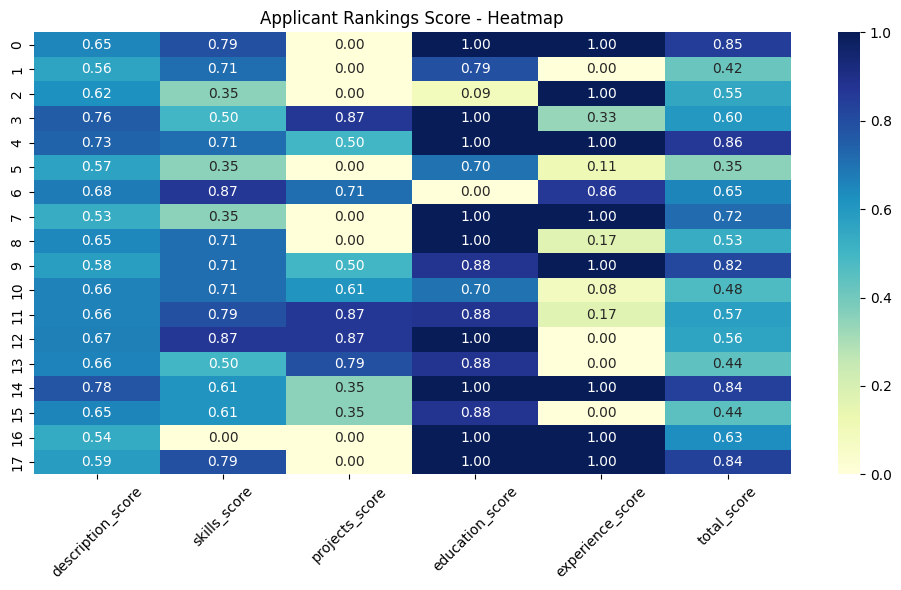

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_heatmap(df):
    columns_to_visualize = ['description_score', 'skills_score', 'projects_score', 'education_score', 'experience_score', 'total_score']
    plt.figure(figsize=(10, 6))
    sns.heatmap(df[columns_to_visualize], cmap='YlGnBu', annot=True, fmt=".2f")
    plt.title('Applicant Rankings Score - Heatmap')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

visualize_heatmap(df_resume)

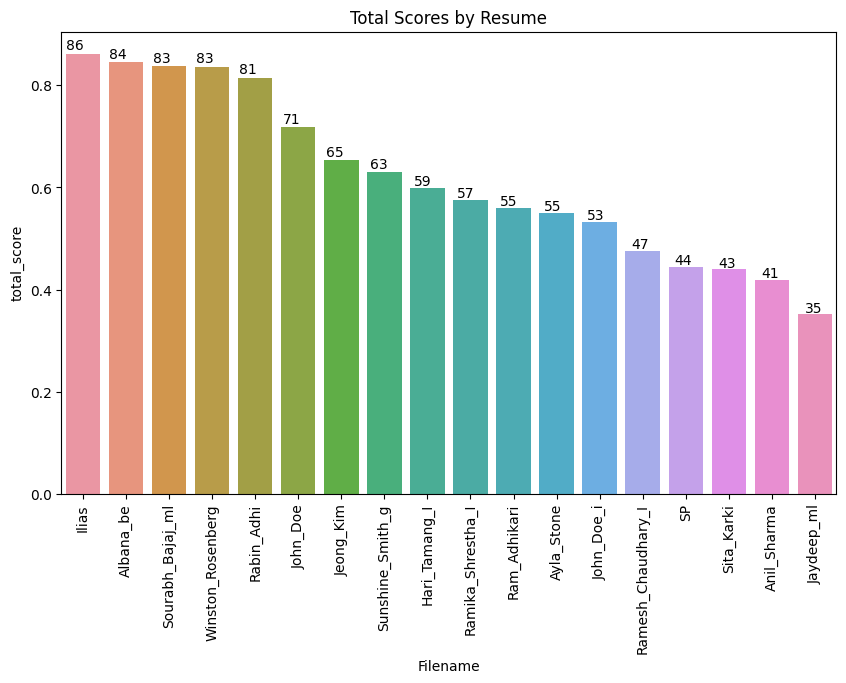

In [170]:
def visualize_total_scores(df_resume):
    # Bar chart for total scores using seaborn
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x="Filename", y="total_score", data=df_resume)
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height()*100)}', (p.get_x()*1.01, p.get_height()*1.01))
    plt.xticks(rotation=90)
    plt.title("Total Scores by Resume")
    plt.show()

visualize_total_scores(df_resume.sort_values(by='total_score', ascending=False))